In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model.models as models
from model.datamodule import MyDataModule
from model.datamodule import MyDataModuleWithRoute
import mylib.route as m_route
import mylib.utils as ut
import mylib.config as conf

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [3]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-21-01-12-input_route_zero_fixdif")
cp_path = os.path.join(log_dir, "cp/last.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [4]:
def plot_route(y, y_hat):
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [5]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

c:\Users\hal\Documents\lab\abci\env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
C:\TEMP\ipykernel_19564\266300590.py:33: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y[:,-20,:].cuda())


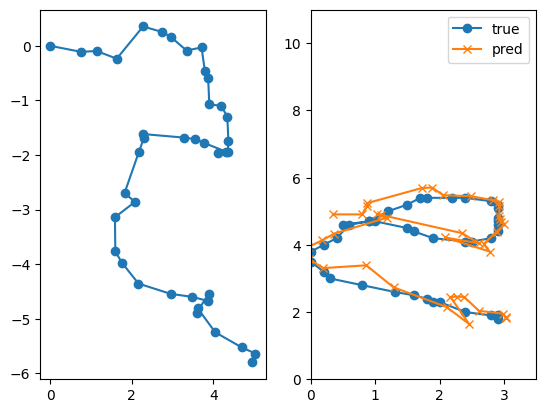

[2.7459362 3.6990452]


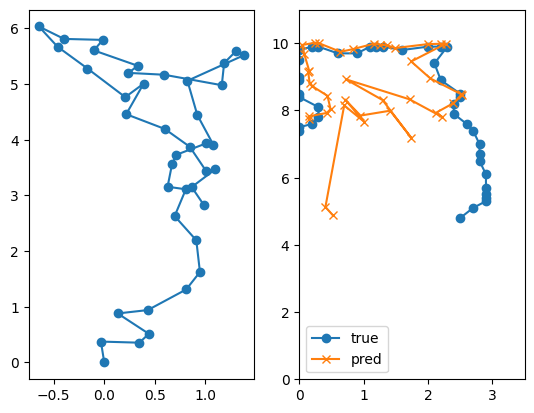

[7.0113244 5.388035 ]


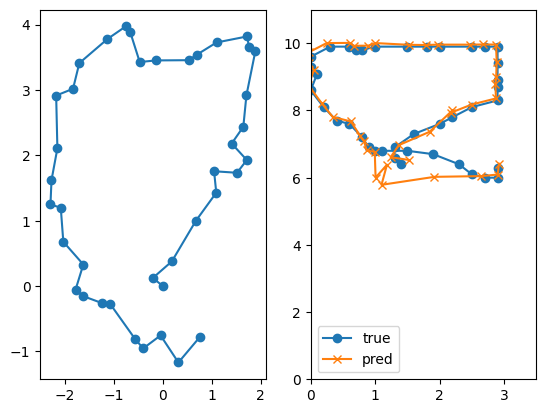

[5.244224  3.6402962]


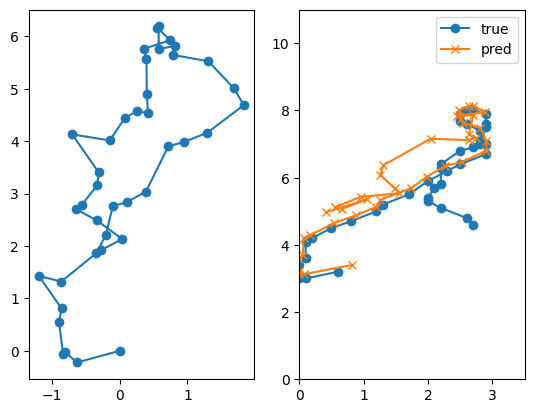

[4.903324  1.6308181]


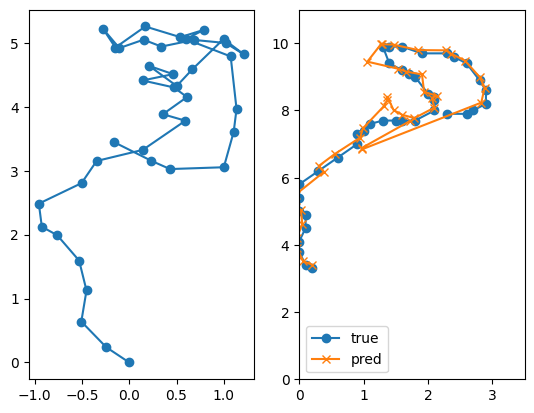

[8.112139 4.527716]


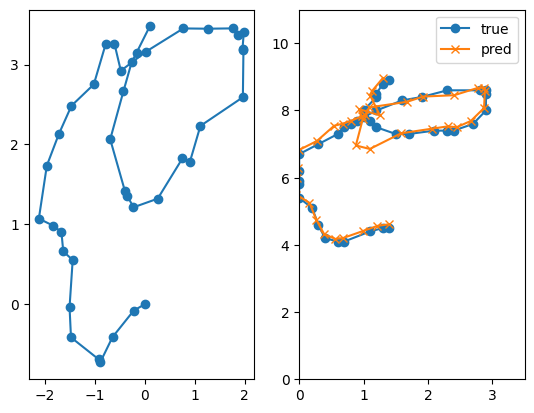

[7.6854606 5.3947253]


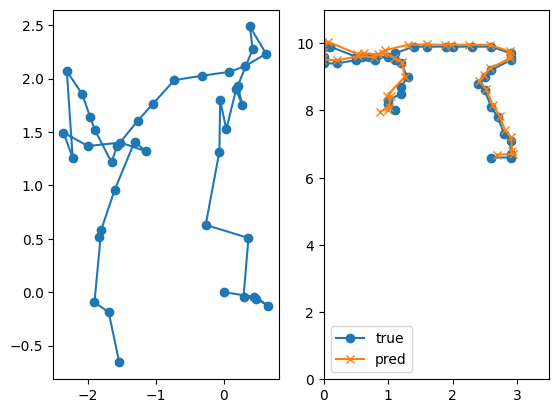

[5.3107643 5.7388496]


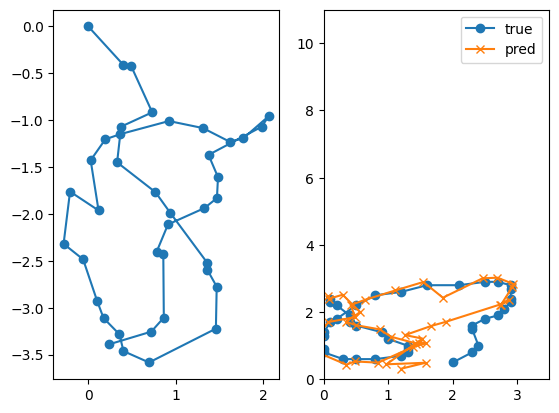

[1.9861389 1.9508731]


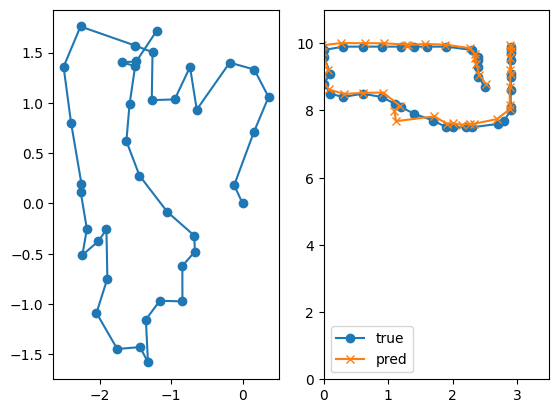

[7.497417 5.933254]


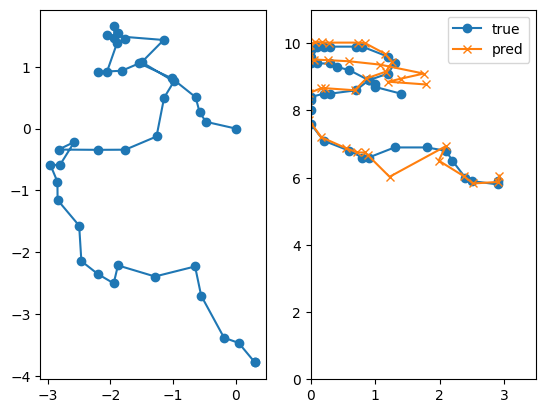

[4.825993  6.5752406]


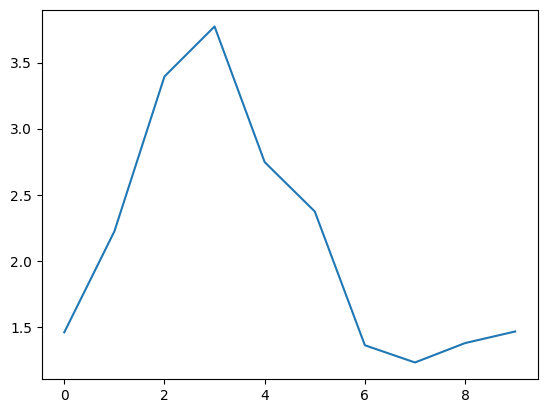

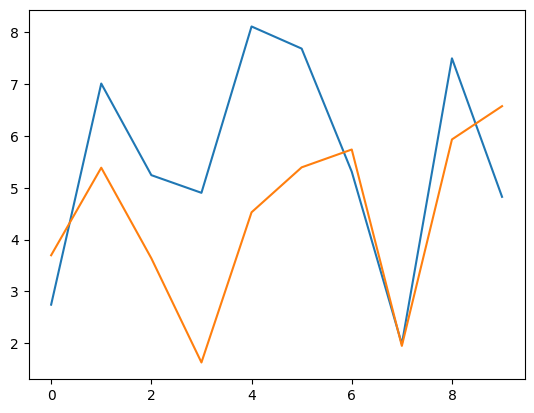

2.140707767009735


In [6]:

ut.fix_seeds(0)

config = conf.from_yaml(config_path)

df = pickle.load(open(DF_PATH, "rb"))
    
config = conf.from_yaml(config_path)

config_route = config["route"]
route_gen = m_route.DistanceRotateRouteGeneraterV1.from_config(config_route)

config_dm = config["dm"]
dm = MyDataModuleWithRoute(n_of_route=config_dm["n_of_route"], batch_size=config_dm["batch_size"], route_gen=route_gen, df=df)


model = models.TransformerWithRoute.load_from_checkpoint(cp_path)
model.eval()


loss_list = []
dist_list = []
for i in range(10):
    # batch = dm.train_dataset[i]
    batch = dm.val_dataset[i]
    x, y = batch
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    y_hat = model(x.cuda())
    # print(x)
    # print(y)
    # print(y_hat)

    loss = nn.functional.mse_loss(y_hat, y[:,-20,:].cuda())
    # print(loss)
    loss_list.append(loss.item())

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    # print(y_hat[0], y[0][-1])
    # plot_route(y, y_hat)
    plot_route2(x, y, y_hat)
    dist = pow(pow(y_hat[0][0] - y[0][-1][0], 2) + pow(y_hat[0][1] - y[0][-1][1], 2), 0.5)
    dist_list.append(dist)  
    print(dist)

    

plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)


In [7]:
# loss = nn.functional.mse_loss(y_hat, y[:,-1,:].cuda())
print(loss)

plt.figure(figsize=(3, 9))

dist_hist = []

for i in range(len(y)):
    x_s = [y[i, -1, 0].cpu().numpy(), y_hat[i, 0].detach().cpu().numpy()]
    y_s = [y[i, -1, 1].cpu().numpy(), y_hat[i, 1].detach().cpu().numpy()]

    

    dist = pow(pow(x_s[0] - x_s[1], 2) + pow(y_s[0] - y_s[1], 2), 0.5)
    dist_hist.append(dist)

    plt.plot(x_s, y_s, marker="o")


plt.xlim(0, 3)
plt.ylim(0, 10)
plt.show()


plt.hist(dist_hist, bins=30)
plt.show()

tensor(1.4657, device='cuda:0', grad_fn=<MseLossBackward0>)


AttributeError: 'numpy.float32' object has no attribute 'cpu'

<Figure size 300x900 with 0 Axes>

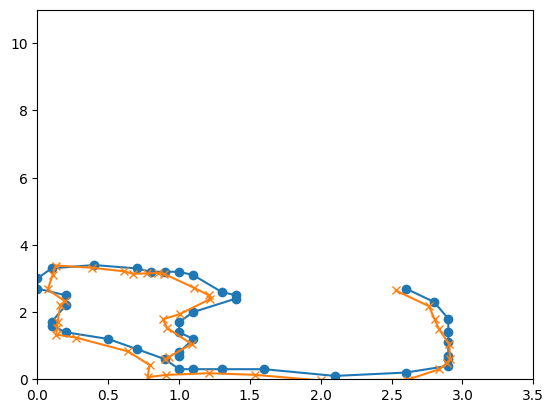

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
for i in range(10):
    plt.plot(y[i, :, 0], y[i, :, 1], marker="o")
    plt.plot(y_hat[i, :, 0], y_hat[i, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()